<a href="https://colab.research.google.com/github/LAworkspace/retail-recommender-MLOPS/blob/main/1_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import polars as pl

# ✅ Step 1: Load the enriched dataset
events = pl.read_parquet("/content/enriched_events_with_conversion (1).parquet")



In [4]:
agg = events.group_by(["visitorid", "sessionid", "itemid"]).agg([
    pl.len().alias("total_events"),
    (pl.col("event") == "view").cast(pl.Int8).sum().alias("view_count"),
    (pl.col("event") == "cart").cast(pl.Int8).sum().alias("added_to_cart"),
    ((pl.max("timestamp") - pl.min("timestamp")).cast(pl.Int64) / 1_000_000_000).alias("dwell_time_secs")
])


In [5]:
events.select("label_interested").head()


label_interested
i8
0
0
0
0
1


TRAINING:


In [6]:
import polars as pl

# Load the enriched parquet file
events = pl.read_parquet("/content/enriched_events_with_conversion (1).parquet")  # Replace with your correct path

# Confirm the label column exists
print(events.columns)
print(events.select("label_interested").head())


['timestamp', 'visitorid', 'event', 'itemid', 'transactionid', 'hour_of_day', 'day_of_week', 'is_new_session', 'session_number', 'sessionid', 'views_last_24h', 'cart_conversion_rate', 'purchase_conversion_rate', 'label_interested']
shape: (5, 1)
┌──────────────────┐
│ label_interested │
│ ---              │
│ i8               │
╞══════════════════╡
│ 0                │
│ 0                │
│ 0                │
│ 0                │
│ 1                │
└──────────────────┘


In [7]:
# Define features & target
feature_cols = [
    "views_last_24h",
    "cart_conversion_rate",
    "purchase_conversion_rate",
    "hour_of_day",
    "day_of_week"
]
target_col = "label_interested"

# Convert to pandas for scikit-learn
df_model = events.select(feature_cols + [target_col]).drop_nulls().to_pandas()


In [8]:
from sklearn.model_selection import train_test_split

X = df_model[feature_cols]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Install LightGBM (if not already)
!pip install lightgbm

import lightgbm as lgb

# Prepare datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "seed": 42
}

# Train
from lightgbm import early_stopping, log_evaluation

model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
    callbacks=[
        early_stopping(stopping_rounds=10),
        log_evaluation(10)
    ]
)




Training until validation scores don't improve for 10 rounds
[10]	valid_0's binary_logloss: 0.552562
[20]	valid_0's binary_logloss: 0.552291
[30]	valid_0's binary_logloss: 0.552172
[40]	valid_0's binary_logloss: 0.552115
[50]	valid_0's binary_logloss: 0.552086
[60]	valid_0's binary_logloss: 0.552068
[70]	valid_0's binary_logloss: 0.552058
[80]	valid_0's binary_logloss: 0.552051
[90]	valid_0's binary_logloss: 0.552047
[100]	valid_0's binary_logloss: 0.552038
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.552038


In [10]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred_labels))
print(classification_report(y_test, y_pred_labels))


[[417786    104]
 [133200    131]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.86    417890
           1       0.56      0.00      0.00    133331

    accuracy                           0.76    551221
   macro avg       0.66      0.50      0.43    551221
weighted avg       0.71      0.76      0.65    551221



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

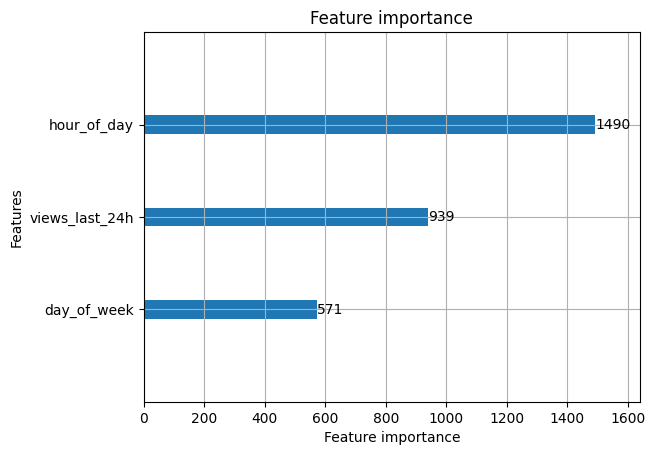

In [11]:
lgb.plot_importance(model, max_num_features=10)


RE-TRAIN 2ND TIME: TO REDUCE CLASS IMBALANCE:

In [12]:
# Updated training parameters
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "is_unbalance": True,  # <--- key change
    "boosting_type": "gbdt",
    "learning_rate": 0.1,
    "num_leaves": 31,
}

# Create LightGBM datasets again (if needed)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Retrain
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.554871


In [13]:
import polars as pl

# Load the events file again (just in case)
events = pl.read_parquet("/content/enriched_events_with_conversion (1).parquet")

# Step 1: Aggregate features
agg = events.group_by(["visitorid", "sessionid", "itemid"]).agg([
    (pl.col("event") == "view").cast(pl.Int8).sum().alias("view_count"),
    (pl.col("event") == "cart").cast(pl.Int8).sum().alias("added_to_cart"),
    (pl.col("timestamp").max() - pl.col("timestamp").min()).dt.cast_time_unit("ms").alias("dwell_time_ms")
])

# Step 2: Convert dwell time to seconds
agg = agg.with_columns(
    (pl.col("dwell_time_ms") / 1000).cast(pl.Int32).alias("dwell_time_secs")
).drop("dwell_time_ms")

# Step 3: Use events as base model_data before join
model_data = events.join(agg, on=["visitorid", "sessionid", "itemid"], how="left")


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.002734
[[521986     96]
 [     9 166935]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    522082
           1       1.00      1.00      1.00    166944

    accuracy                           1.00    689026
   macro avg       1.00      1.00      1.00    689026
weighted avg       1.00      1.00      1.00    689026



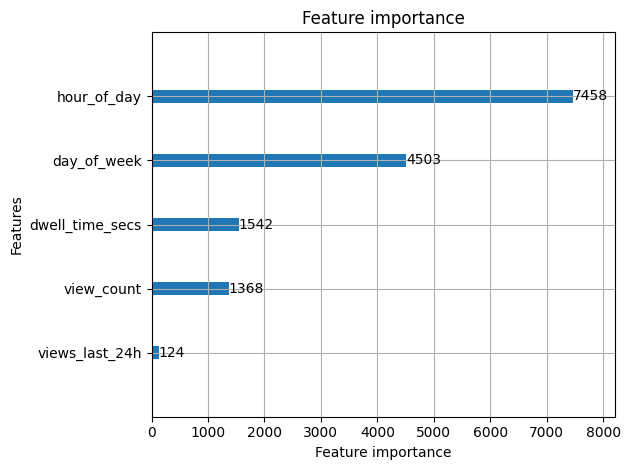

In [14]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ✅ Step 1: Define full feature list
feature_cols = [
    "hour_of_day", "day_of_week", "views_last_24h",
    "view_count", "added_to_cart", "dwell_time_secs"
]
target_col = "label_interested"

# ✅ Step 2: Prepare data
df_model = model_data.select(feature_cols + [target_col]).to_pandas()
X = df_model[feature_cols]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# ✅ Step 3: Set params with smaller learning rate
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "is_unbalance": True,
    "boosting_type": "gbdt",
    "learning_rate": 0.01,
    "num_leaves": 31
}

# ✅ Step 4: Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=20)]
)

# ✅ Step 5: Evaluate
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ✅ Step 6: Feature importance plot
lgb.plot_importance(model)
plt.tight_layout()
plt.show()


In [15]:
model_data.columns



['timestamp',
 'visitorid',
 'event',
 'itemid',
 'transactionid',
 'hour_of_day',
 'day_of_week',
 'is_new_session',
 'session_number',
 'sessionid',
 'views_last_24h',
 'cart_conversion_rate',
 'purchase_conversion_rate',
 'label_interested',
 'view_count',
 'added_to_cart',
 'dwell_time_secs']

In [16]:
model_data = model_data.with_columns(
    pl.col("timestamp").cast(pl.Datetime)
)


In [17]:
ts_bounds = model_data.select([
    pl.col("timestamp").min().alias("min_ts"),
    pl.col("timestamp").max().alias("max_ts")
])

min_ts = ts_bounds[0, "min_ts"]
max_ts = ts_bounds[0, "max_ts"]


In [18]:
split_ts = min_ts + (max_ts - min_ts) * 0.8


In [19]:
train_data = model_data.filter(pl.col("timestamp") < split_ts)
test_data = model_data.filter(pl.col("timestamp") >= split_ts)

# Optional: Check sizes
print("Train:", train_data.shape)
print("Test:", test_data.shape)


Train: (2266414, 17)
Test: (489687, 17)


Extract Features and Target from Polars

In [20]:
# Feature columns (based on your enriched features)
feature_cols = [
    "hour_of_day", "day_of_week", "is_new_session", "session_number",
    "views_last_24h", "cart_conversion_rate", "purchase_conversion_rate",
    "view_count", "added_to_cart", "dwell_time_secs"
]
target_col = "label_interested"

# Convert to pandas for LightGBM
df_train = train_data.select(feature_cols + [target_col]).to_pandas()
df_test = test_data.select(feature_cols + [target_col]).to_pandas()

X_train = df_train[feature_cols]
y_train = df_train[target_col]
X_test = df_test[feature_cols]
y_test = df_test[target_col]


In [21]:
import lightgbm as lgb

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "learning_rate": 0.01,
    "boosting_type": "gbdt",
    "verbosity": -1
}

train_dataset = lgb.Dataset(X_train, label=y_train)
valid_dataset = lgb.Dataset(X_test, label=y_test)

model = lgb.train(
    params,
    train_dataset,
    valid_sets=[valid_dataset],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)  # Add this
    ]
)



Training until validation scores don't improve for 50 rounds
[50]	valid_0's binary_logloss: 0.262734
[100]	valid_0's binary_logloss: 0.146613
[150]	valid_0's binary_logloss: 0.0853029
[200]	valid_0's binary_logloss: 0.05064
[250]	valid_0's binary_logloss: 0.0304219
[300]	valid_0's binary_logloss: 0.0184325
[350]	valid_0's binary_logloss: 0.0112589
[400]	valid_0's binary_logloss: 0.00694198
[450]	valid_0's binary_logloss: 0.00433827
[500]	valid_0's binary_logloss: 0.00276481
[550]	valid_0's binary_logloss: 0.00181253
[600]	valid_0's binary_logloss: 0.00123631
[650]	valid_0's binary_logloss: 0.000888026
[700]	valid_0's binary_logloss: 0.000675528
[750]	valid_0's binary_logloss: 0.000546641
[800]	valid_0's binary_logloss: 0.000471018
[850]	valid_0's binary_logloss: 0.000425582
[900]	valid_0's binary_logloss: 0.000400713
[950]	valid_0's binary_logloss: 0.000386738
[1000]	valid_0's binary_logloss: 0.000378056
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_proba > 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))


[[378627     43]
 [    56 110961]]
              precision    recall  f1-score   support

           0     0.9999    0.9999    0.9999    378670
           1     0.9996    0.9995    0.9996    111017

    accuracy                         0.9998    489687
   macro avg     0.9997    0.9997    0.9997    489687
weighted avg     0.9998    0.9998    0.9998    489687



In [23]:
pip install mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.2/676.2 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 15.0 MB/s eta 0:00:00


In [24]:
import mlflow
import mlflow.lightgbm

mlflow.set_experiment("interest-prediction")


2025/07/23 05:24:20 INFO mlflow.tracking.fluent: Experiment with name 'interest-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///content/mlruns/736616955481254298', creation_time=1753248260126, experiment_id='736616955481254298', last_update_time=1753248260126, lifecycle_stage='active', name='interest-prediction', tags={}>

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.00276481


2025/07/23 05:26:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 05:26:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


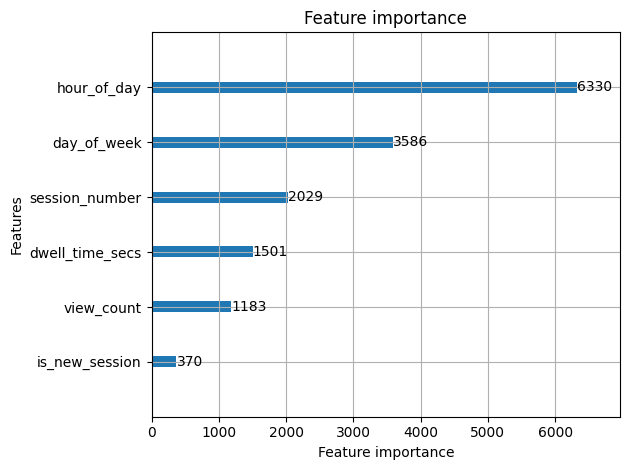

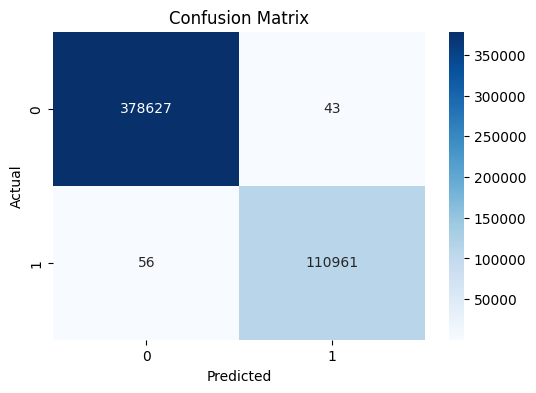

In [26]:
with mlflow.start_run():
    # Log LightGBM parameters
    mlflow.log_params(params)

    # Create LightGBM Datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Train the model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=20)]
    )

    # Predictions
    y_pred = (model.predict(X_test, num_iteration=model.best_iteration) > 0.5).astype(int)

    # Evaluation
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("accuracy", report["accuracy"])
    mlflow.log_metric("precision_0", report["0"]["precision"])
    mlflow.log_metric("recall_0", report["0"]["recall"])
    mlflow.log_metric("f1_0", report["0"]["f1-score"])
    mlflow.log_metric("precision_1", report["1"]["precision"])
    mlflow.log_metric("recall_1", report["1"]["recall"])
    mlflow.log_metric("f1_1", report["1"]["f1-score"])

    # Log model
    mlflow.lightgbm.log_model(model, "model")

    # Log feature importance plot
    fig = lgb.plot_importance(model)
    plt.tight_layout()
    plot_path = "feature_importance.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

    # Optionally log confusion matrix
    import seaborn as sns
    import pandas as pd

    plt.figure(figsize=(6, 4))
    sns.heatmap(pd.DataFrame(cm), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    cm_path = "confusion_matrix.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)


In [30]:
!pip install mlflow pyngrok --quiet


In [32]:
!ngrok config add-authtoken 30GM66SkZLdUsXin2Cigb419YwP_5MwXcsEfgG4AQBmLHfkvD

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import mlflow
from pyngrok import ngrok

# Kill any existing tunnels
ngrok.kill()

# Start MLflow UI on port 5000
mlflow_port = 5000
mlflow_uri = f"http://127.0.0.1:{mlflow_port}"
ngrok_tunnel = ngrok.connect(mlflow_port)
print(f"MLflow UI available at: {ngrok_tunnel.public_url}")

# Launch MLflow UI (non-blocking)
!mlflow ui --port 5000 --host 127.0.0.1 &


MLflow UI available at: https://efd9def31a6f.ngrok-free.app
[2025-07-23 05:49:46 +0000] [9784] [INFO] Starting gunicorn 23.0.0
[2025-07-23 05:49:46 +0000] [9784] [INFO] Listening at: http://127.0.0.1:5000 (9784)
[2025-07-23 05:49:46 +0000] [9784] [INFO] Using worker: sync
[2025-07-23 05:49:46 +0000] [9789] [INFO] Booting worker with pid: 9789
[2025-07-23 05:49:46 +0000] [9790] [INFO] Booting worker with pid: 9790
[2025-07-23 05:49:46 +0000] [9791] [INFO] Booting worker with pid: 9791
[2025-07-23 05:49:46 +0000] [9792] [INFO] Booting worker with pid: 9792


In [34]:
import mlflow
import mlflow.lightgbm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define experiment name
mlflow.set_experiment("lightgbm-interest-prediction")

with mlflow.start_run():

    # Log parameters
    mlflow.log_params(params)

    # Train model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=500,
        valid_sets=[test_data],
        callbacks=[lgb.early_stopping(stopping_rounds=20)]
    )

    # Predict and evaluate
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("precision", prec)
    mlflow.log_metric("recall", rec)
    mlflow.log_metric("f1_score", f1)

    # Log model
    mlflow.lightgbm.log_model(model, "model")


2025/07/23 05:47:54 INFO mlflow.tracking.fluent: Experiment with name 'lightgbm-interest-prediction' does not exist. Creating a new experiment.


Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's binary_logloss: 0.00276481


2025/07/23 05:49:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/23 05:49:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
